# Taller 1

Wilberson Osorio, Juan Jeronimo Manriquez

In [1]:
%%capture
!apt-get update -y && apt-get install -y colmap
!pip install open3d
!pip install pycolmap

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

import os
import random
import shutil
from PIL import Image, ImageOps

import pycolmap
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# CORRER ESTO SI SE NECESITA REPLICAR EL PROCESO DESDE EL INICIO!
"""
up = os.path.join(os.path.abspath(""), '..')

carpeta_corregida = up + "/process/imagenes_corregidas"
carpeta_colmap = up + "/process/colmap"
carpeta_output = up + "/process/output"

shutil.rmtree(carpeta_corregida)
shutil.rmtree(carpeta_colmap)
shutil.rmtree(carpeta_output)
"""

'\nup = os.path.join(os.path.abspath(""), \'..\')\n\ncarpeta_corregida = up + "/process/imagenes_corregidas"\ncarpeta_colmap = up + "/process/colmap"\ncarpeta_output = up + "/process/output"\n\nshutil.rmtree(carpeta_corregida)\nshutil.rmtree(carpeta_colmap)\nshutil.rmtree(carpeta_output)\n'

## Paso 2: Preprocesamiento de Imágenes

In [4]:
# Matriz de calibración (Conseguida con el ejercicio de chessboard)
mtx = np.array([
    [4.94196706e+04, 0.00000000e+00, 4.41554681e+02],
    [0.00000000e+00, 9.25708388e+04, 1.04911904e+02],
    [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]
])

# Matriz de distorsión
dist = np.array([[-3.77575432e+01, -4.51518076e+00, 2.35023031e-01, -5.25093514e-01, -8.86047623e-04]])

In [5]:
up = os.path.join(os.path.abspath(""), '..')

input_folder = up + "/imagenes"
carpeta_corregida = up + "/process/imagenes_corregidas"
carpeta_colmap = up + "/process/colmap"
carpeta_output = up + "/process/output"

os.makedirs(input_folder, exist_ok=True)
os.makedirs(carpeta_corregida, exist_ok=True)
os.makedirs(carpeta_colmap, exist_ok=True)
os.makedirs(carpeta_output, exist_ok=True)

In [6]:
# Preprocesamos las imagenes

clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))

i = 1
for archivo in os.listdir(input_folder):
    if archivo.endswith((".jpg", ".png", ".jpeg")):
        ruta_original = os.path.join(input_folder, archivo)

        img = cv2.imread(ruta_original)
        h, w = img.shape[:2]

        # Obtener nueva matriz óptima sin distorsión
        new_mtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w, h), 0, (w, h))

        # Aplicar la corrección de distorsión
        img_undistorted = cv2.undistort(img, mtx, dist, None, new_mtx)

        # EL CODIGO ABAJO ESTA COMENTADO YA QUE FUNCIONA MEJOR CON LAS IMAGENES DE PRUEBA A COLOR!!!
        # img_undistorted = cv2.cvtColor(img_undistorted, cv2.COLOR_BGR2GRAY)
        # Aplicar mejora de contraste
        # img_undistorted = clahe.apply(img_undistorted)

        # Guardar la imagen corregida
        output = str(i) + ".jpeg"
        ruta_corregida = os.path.join(carpeta_corregida, output)
        cv2.imwrite(ruta_corregida, img_undistorted)
        i += 1

## Paso 3: Detección de Características y Emparejamiento

In [7]:
archivo_db = carpeta_colmap + "/database.db"
if (not os.path.exists(archivo_db)):
  archivo = open(archivo_db, "x")
  archivo.close()

In [8]:
pycolmap.set_random_seed(413) # Asi da resultados consistentes  :)

ops = pycolmap.SiftExtractionOptions()
ops.estimate_affine_shape = True
ops.domain_size_pooling = True
#ops.first_octave = -1

pycolmap.extract_features(archivo_db, carpeta_corregida, sift_options=ops)

El proceso de detección de características también se puede hacer con *Opencv*, pero para hacer la reconstrucción con Colmap se requiere hacer una transformación y almacenar esos datos en el formato especifico de Colmap, lo cual es no es necesario, ya que con pycolmap se puede hacer este proceso de forma simple, siendo así, con finales demostrativos se realizará el emparejamiento con ORB.

In [9]:
imagenes = []
nombres_imagenes = []

for archivo in os.listdir(carpeta_corregida):
    if archivo.endswith(".jpeg"):
        ruta = os.path.join(carpeta_corregida, archivo)
        image = cv2.imread(ruta)
        imagenes.append(image)
        nombres_imagenes.append(carpeta_corregida)

orb = cv2.ORB_create()
array_puntos = []
array_descriptores = []

for img in imagenes:
    puntos, descriptores = orb.detectAndCompute(img, None)
    array_puntos.append(puntos)
    array_descriptores.append(descriptores)

array_random = [x for x in range(0, len(imagenes))]

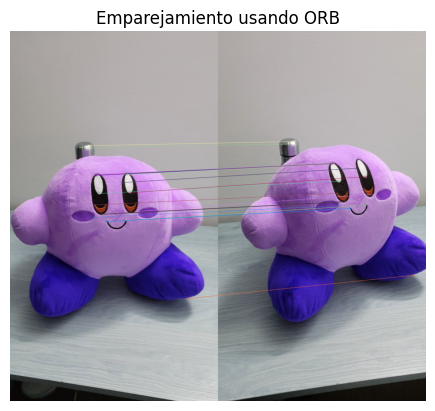

In [11]:
img1, img2 = random.choices(array_random, k = 2)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(array_descriptores[img1], array_descriptores[img2])

matches = sorted(matches, key = lambda x:x.distance)

img3 = cv2.drawMatches(imagenes[img1], array_puntos[img1], imagenes[img2], array_puntos[img2], matches[:25],None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.imshow(img3)
plt.title(f"Emparejamiento usando ORB")
plt.axis("off")
plt.show()

## Paso 4: Estimación de la Matriz Fundamental y la Matriz Esencial

In [12]:
pycolmap.match_exhaustive(archivo_db)

Aunque Colmap haga esto automáticamente para todas las imágenes, se pueden conseguir estas matrices manualmente en caso de que fueran necesarias.

In [13]:
ransac_options = pycolmap.RANSACOptions(
    confidence=0.99,
    min_num_trials=1000,
    max_num_trials=10000
)

db = pycolmap.Database(archivo_db)
puntos1 = db.read_keypoints(1)
puntos2 = db.read_keypoints(2)
camara1 = db.read_camera(1)
camara2 = db.read_camera(2)
db.close()

puntos1 = puntos1[:10, :2]
puntos2 = puntos2[:10, :2]

fundamental = pycolmap.estimate_fundamental_matrix(
    puntos1,
    puntos2,
)

essencial = pycolmap.estimate_essential_matrix(
    puntos1,
    puntos2,
    camara1,
    camara2
)

In [14]:
print(fundamental)

{'F': array([[ 3.50002549e-07,  7.87660805e-08, -2.60560314e-04],
       [ 8.59967787e-07,  7.33009782e-07, -1.05227251e-03],
       [-8.34533510e-04, -6.83638397e-04,  9.99998831e-01]]), 'num_inliers': 8, 'inlier_mask': array([False,  True,  True,  True, False,  True,  True,  True,  True,
        True])}


In [15]:
print(essencial['cam2_from_cam1'])

Rigid3d(rotation_xyzw=[0.927408, -0.371561, -0.0416291, -0.0111454], translation=[0.119365, -0.0820166, 0.989457])


## Paso 5: Reconstrucción 3D

In [16]:
mapping_options = pycolmap.IncrementalPipelineOptions()
mapping_options.ba_global_max_num_iterations = 100

# Ejecutar la reconstrucción incremental
reconstructions = pycolmap.incremental_mapping(
    database_path=archivo_db,
    image_path=carpeta_corregida,
    output_path=carpeta_output,
    options=mapping_options
)

for idx, reconstruction in reconstructions.items():
    reconstruction.write(os.path.join(carpeta_output, str(idx)))

## Paso 6: Visualización del Modelo 3D

In [17]:
puntos = os.path.join(carpeta_output, '0')
points3D = pycolmap.Reconstruction(puntos).points3D

# Crear un objeto PointCloud de Open3D
nube_puntos = o3d.geometry.PointCloud()

# Extraer coordenadas y colores
puntos = np.array([p.xyz for p in points3D.values()])
colores = np.array([p.color / 255.0 for p in points3D.values()])  # Normalizar colores

# Asignar puntos y colores
nube_puntos.points = o3d.utility.Vector3dVector(puntos)
nube_puntos.colors = o3d.utility.Vector3dVector(colores)

# Guardar en formato PLY
ruta_ply = f"{carpeta_output}/points3D.ply"
o3d.io.write_point_cloud(ruta_ply, nube_puntos)

True

In [18]:
# NO FUNCIONA EN COLAB!!!!!!!!

puntos = os.path.join(carpeta_output, 'points3D.ply')
nube_puntos = o3d.io.read_point_cloud(puntos)

# Mostrar información básica
print(nube_puntos)
print("Número de puntos en la nube:", len(nube_puntos.points))

# Visualizar la nube de puntos
o3d.visualization.draw_geometries([nube_puntos], window_name="Nube de Puntos 3D")

PointCloud with 6265 points.
Número de puntos en la nube: 6265
